<a href="https://colab.research.google.com/github/avinashthombre/public/blob/master/Cab_Surge_Pricing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction - Surge Pricing for Cabs 

Dynamic pricing, also referred to as surge pricing, demand pricing, or time-based pricing is a pricing strategy in which businesses set flexible prices for products or services based on current market demands.


In [1]:
# Importing required libraries
import numpy as np # for mathmatical computations on data
import pandas as pd # for data cleaning, processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from plotly import express as px

In [2]:
# Importing packages for models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Data Import and Description

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (2).csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
1,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
2,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
3,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2
4,T0005689469,19.06,E,10.0,NaN,NaN,A,2.59750,1,72.0,63,91,Male,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109522 entries, 0 to 109521
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      109522 non-null  object 
 1   Trip_Distance                109522 non-null  float64
 2   Type_of_Cab                  92757 non-null   object 
 3   Customer_Since_Months        104619 non-null  float64
 4   Life_Style_Index             92672 non-null   float64
 5   Confidence_Life_Style_Index  92672 non-null   object 
 6   Destination_Type             109522 non-null  object 
 7   Customer_Rating              109522 non-null  float64
 8   Cancellation_Last_1Month     109522 non-null  int64  
 9   Var1                         50363 non-null   float64
 10  Var2                         109522 non-null  int64  
 11  Var3                         109522 non-null  int64  
 12  Gender                       109522 non-null  object 
 13 

In [6]:
df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,109522.000000,104619.000000,92672.000000,109522.000000,109522.000000,50363.000000,109522.000000,109522.000000,109522.000000
mean,44.163371,6.020876,2.802270,2.849416,0.782519,64.169251,51.200307,75.088238,2.154928
std,25.515867,3.625908,0.225523,0.982128,1.036107,21.838095,4.983502,11.582581,0.738416
min,1.530000,0.000000,1.656960,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.550000,3.000000,2.654880,2.150000,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.190000,6.000000,2.797640,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.710000,10.000000,2.946798,3.585000,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [7]:
df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    16765
Customer_Since_Months           4903
Life_Style_Index               16850
Confidence_Life_Style_Index    16850
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           59159
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

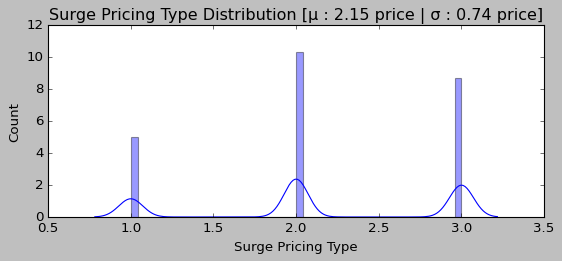

In [8]:
# Plotting the distribution of target variable

plt.style.use("classic")
plt.figure(figsize=(8, 3))
sns.distplot(df['Surge_Pricing_Type'], color='blue')
plt.title(f"Surge Pricing Type Distribution [\u03BC : {df['Surge_Pricing_Type'].mean():.2f} price | \u03C3 : {df['Surge_Pricing_Type'].std():.2f} price]")
plt.xlabel("Surge Pricing Type")
plt.ylabel("Count")
plt.show()

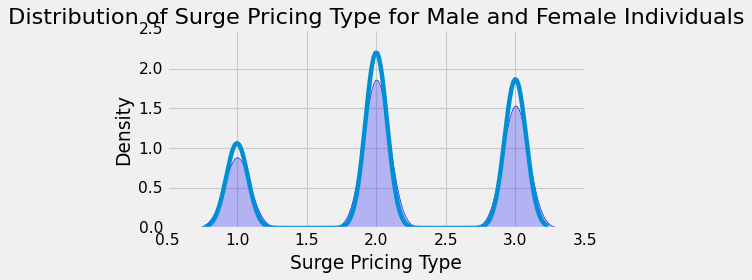

In [9]:
# Plotting target variable and gender
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 3))
sns.kdeplot(df.loc[df['Gender'] == 'Male', 'Surge_Pricing_Type'], label = 'Male',shade=False)
sns.kdeplot(df.loc[df['Gender'] == 'Female', 'Surge_Pricing_Type'], label = 'Female',shade=True)

# Labeling of plot
plt.xlabel('Surge Pricing Type')
plt.ylabel('Density')
plt.title('Distribution of Surge Pricing Type for Male and Female Individuals')
plt.show()

In [10]:
# Pie Chart to see gender of individuals in surge pricing
targets = df['Gender'].value_counts().tolist()
values = list(dict(df['Gender'].value_counts()).keys())

fig = plt.figure(figsize=(6,3))
fig = px.pie(
    values=targets, 
    names=values,
    title='Gender of Individuals in Taxi Surge Pricing',
    color_discrete_sequence=['red', 'navy']
)
fig.show()

<Figure size 480x240 with 0 Axes>

In [11]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
Trip_Distance,1.000000,0.117303,0.508792,-0.055674,-0.005287,-0.050401,0.200322,0.232650,0.137321
Customer_Since_Months,0.117303,1.000000,0.132987,-0.050916,-0.006372,-0.008397,0.042638,0.113511,0.027423
Life_Style_Index,0.508792,0.132987,1.000000,0.206951,0.075607,-0.093338,0.232264,0.327558,-0.078119
Customer_Rating,-0.055674,-0.050916,0.206951,1.000000,0.003936,-0.011717,-0.302017,-0.226520,-0.156422
Cancellation_Last_1Month,-0.005287,-0.006372,0.075607,0.003936,1.000000,0.010817,0.095785,0.127563,0.188505
Var1,-0.050401,-0.008397,-0.093338,-0.011717,0.010817,1.000000,-0.049990,-0.065479,-0.043574
Var2,0.200322,0.042638,0.232264,-0.302017,0.095785,-0.049990,1.000000,0.683407,0.004325
Var3,0.232650,0.113511,0.327558,-0.226520,0.127563,-0.065479,0.683407,1.000000,-0.038748
Surge_Pricing_Type,0.137321,0.027423,-0.078119,-0.156422,0.188505,-0.043574,0.004325,-0.038748,1.000000


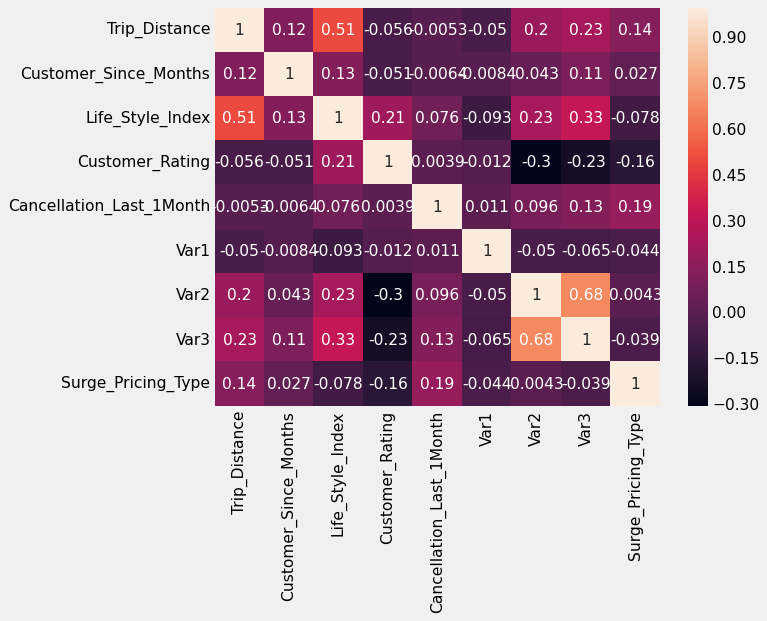

In [12]:
import seaborn as sns

Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

# Data Processing

Initial steps involve data cleaning like removing null values, filling null values with non-zero values, etc.

In [13]:
df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    16765
Customer_Since_Months           4903
Life_Style_Index               16850
Confidence_Life_Style_Index    16850
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           59159
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [14]:
df["Type_of_Cab"].value_counts()

B    25959
C    23306
A    18028
D    15752
E     9712
Name: Type_of_Cab, dtype: int64

In [15]:
# The null value cabs will be assigned to "F"
df["Type_of_Cab"] = df["Type_of_Cab"].fillna("F")

In [16]:
df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                        0
Customer_Since_Months           4903
Life_Style_Index               16850
Confidence_Life_Style_Index    16850
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           59159
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [17]:
avg = df["Customer_Since_Months"].mean()
df["Customer_Since_Months"] = df["Customer_Since_Months"].fillna(round(avg))

In [18]:
df["Life_Style_Index"].value_counts()

2.70697    13
2.78127    11
2.78465    11
2.78388    11
2.77608    11
           ..
2.58879     1
2.63534     1
2.97586     1
2.98463     1
2.82874     1
Name: Life_Style_Index, Length: 50876, dtype: int64

In [19]:
df["Life_Style_Index"].describe()

count    92672.000000
mean         2.802270
std          0.225523
min          1.656960
25%          2.654880
50%          2.797640
75%          2.946798
max          4.875110
Name: Life_Style_Index, dtype: float64

In [20]:
df["Confidence_Life_Style_Index"].value_counts()

B    33556
C    29914
A    29202
Name: Confidence_Life_Style_Index, dtype: int64

In [21]:
df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                        0
Customer_Since_Months              0
Life_Style_Index               16850
Confidence_Life_Style_Index    16850
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           59159
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [22]:
df = df.dropna(subset=["Life_Style_Index"])

In [23]:
df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                        0
Customer_Since_Months              0
Life_Style_Index                   0
Confidence_Life_Style_Index        0
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           49976
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [24]:
# Replacing nan values in Var1 by average rounded to 0 decimals
Var1_avg = df["Var1"].mean()
df["Var1"] = df["Var1"].fillna(round(Var1_avg))

In [25]:
df.isnull().sum()

Trip_ID                        0
Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

In [26]:
# Define function to one-hot-encode the column values
def one_hot_encoding(column):
     df = pd.get_dummies(column,drop_first=True)
     return df

In [27]:
Type_Of_Cab = one_hot_encoding(df["Type_of_Cab"])
Confidence_Life_Style_Index = one_hot_encoding(df["Confidence_Life_Style_Index"])
Destination_Type = one_hot_encoding(df["Destination_Type"])
Gender = one_hot_encoding(df["Gender"])
Type_Of_Cab = Type_Of_Cab.rename(columns={'B': 'Type_Of_Cab_B','C': 'Type_Of_Cab_C','D': 'Type_Of_Cab_D','E': 'Type_Of_Cab_E','F': 'Type_Of_Cab_F'})
Confidence_Life_Style_Index = Confidence_Life_Style_Index.rename(columns = {"B":"Confidence_Life_Style_Index_B","C":"Confidence_Life_Style_Index_C"})
Destination_Type = Destination_Type.rename(columns = {'B':'Destination_Type_B','C':'Destination_Type_C','D':'Destination_Type_D','E':'Destination_Type_E','F':'Destination_Type_F','G':'Destination_Type_G','H':'Destination_Type_H','I':'Destination_Type_I','J':'Destination_Type_J','K':'Destination_Type_K','L':'Destination_Type_L','M':'Destination_Type_M','N':'Destination_Type_N'})
print("Column names have been updated!")

Column names have been updated!


In [28]:
df_one_hot_encoded = pd.concat([df,Type_Of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender], axis=1)

In [29]:
df_one_hot_encoded

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type,Type_Of_Cab_B,Type_Of_Cab_C,Type_Of_Cab_D,Type_Of_Cab_E,Type_Of_Cab_F,Confidence_Life_Style_Index_B,Confidence_Life_Style_Index_C,Destination_Type_B,Destination_Type_C,Destination_Type_D,Destination_Type_E,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Male
0,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,T0005689470,29.72,E,10.0,2.83958,C,B,2.97500,1,83.0,50,75,Male,2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6,T0005689472,18.44,B,2.0,2.81871,B,A,3.58250,0,103.0,46,63,Male,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,T0005689474,107.19,D,5.0,3.04467,B,A,2.44375,1,64.0,58,83,Male,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109516,T0005908498,20.42,B,3.0,2.59182,C,G,4.79750,1,64.0,45,63,Male,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
109518,T0005908507,20.18,F,10.0,2.69374,C,F,4.52625,1,48.0,47,62,Female,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
109519,T0005908509,11.72,D,1.0,2.74229,A,A,3.28500,0,61.0,47,76,Male,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
109520,T0005908510,74.81,C,7.0,2.81059,C,A,0.44500,0,64.0,63,88,Male,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
cols_to_drop = ["Trip_ID","Type_of_Cab","Confidence_Life_Style_Index","Destination_Type","Gender"]
df_final = df_one_hot_encoded.drop(cols_to_drop,axis = 1)

In [31]:
cols_to_be_normalized = ['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index','Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3']
cols_not_to_be_normalized = ['Type_Of_Cab_B', 'Type_Of_Cab_C', 'Type_Of_Cab_D', 'Type_Of_Cab_E','Type_Of_Cab_F', 
                            'Confidence_Life_Style_Index_B','Confidence_Life_Style_Index_C', 'Destination_Type_B',
                            'Destination_Type_C', 'Destination_Type_D', 'Destination_Type_E',
                            'Destination_Type_F', 'Destination_Type_G', 'Destination_Type_H',
                            'Destination_Type_I', 'Destination_Type_J', 'Destination_Type_K',
                            'Destination_Type_L', 'Destination_Type_M', 'Destination_Type_N',
                            'Male','Surge_Pricing_Type']

In [32]:
normalize = normalize(df_final[cols_to_be_normalized])
normalize = pd.DataFrame(normalize,columns=cols_to_be_normalized)
binarized = df_final[cols_not_to_be_normalized].reset_index(drop = True)
df_final =  pd.concat([normalize,binarized], axis=1)

In [33]:
df_final

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_Of_Cab_B,Type_Of_Cab_C,Type_Of_Cab_D,Type_Of_Cab_E,Type_Of_Cab_F,Confidence_Life_Style_Index_B,Confidence_Life_Style_Index_C,Destination_Type_B,Destination_Type_C,Destination_Type_D,Destination_Type_E,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Male,Surge_Pricing_Type
0,0.273009,0.092640,0.025777,0.031961,0.000000,0.352031,0.518783,0.722590,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
1,0.403322,0.073398,0.022273,0.024974,0.029359,0.374330,0.359650,0.748660,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,0.234846,0.079019,0.022438,0.023508,0.007902,0.655861,0.395097,0.592646,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2
3,0.141184,0.015313,0.021581,0.027429,0.000000,0.788611,0.352195,0.482354,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
4,0.666304,0.031081,0.018926,0.015191,0.006216,0.397831,0.360534,0.515937,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92667,0.198837,0.029212,0.025238,0.046715,0.009737,0.623191,0.438181,0.613454,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
92668,0.213992,0.106042,0.028565,0.047997,0.010604,0.509000,0.498396,0.657458,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
92669,0.107606,0.009181,0.025178,0.030161,0.000000,0.560065,0.431526,0.697786,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
92670,0.510644,0.047781,0.019185,0.003038,0.000000,0.436856,0.430030,0.600677,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2


# Data Splitting

In [34]:
X = df_final.drop("Surge_Pricing_Type",axis = 1)
Y = df_final["Surge_Pricing_Type"] 

In [35]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=8,test_size=0.3,stratify=Y)

In [36]:
print(X_train.shape, Y_train.shape)

(64870, 29) (64870,)


In [37]:
print(X_test.shape, Y_test.shape)

(27802, 29) (27802,)


# Model Building and Training


In [38]:
log_model = LogisticRegression()
log_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
Y_pred = log_model.predict(X_test)

In [40]:
accuracy_score(Y_test,Y_pred)

0.6864254370189194

In [41]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.72      0.54      0.62      5754
           2       0.66      0.79      0.72     12001
           3       0.71      0.64      0.67     10047

    accuracy                           0.69     27802
   macro avg       0.70      0.66      0.67     27802
weighted avg       0.69      0.69      0.68     27802



In [42]:
rf_model = RandomForestClassifier(n_jobs=1,random_state=42)

In [43]:
rf_model.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
Y_pred = rf_model.predict(X_test)

In [45]:
accuracy_score(Y_test,Y_pred)

0.6887633983166679

In [46]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.73      0.55      0.63      5754
           2       0.67      0.77      0.72     12001
           3       0.70      0.67      0.68     10047

    accuracy                           0.69     27802
   macro avg       0.70      0.66      0.68     27802
weighted avg       0.69      0.69      0.69     27802



In [47]:
XGB_model = XGBClassifier()

In [48]:
XGB_model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
Y_pred = XGB_model.predict(X_test)

In [50]:
accuracy_score(Y_pred,Y_test)

0.6904179555427667

In [51]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.76      0.52      0.62      5754
           2       0.66      0.80      0.72     12001
           3       0.71      0.66      0.68     10047

    accuracy                           0.69     27802
   macro avg       0.71      0.66      0.67     27802
weighted avg       0.70      0.69      0.69     27802



# Model Evaluation


The three main metrics used to evaluate a classification model are accuracy, precision, and recall. From the above the models used for classification, XGBoost performs the best.